In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
# precomputed mean and stddev
mean_gray = 0.1307
stddev_gray = 0.3081

# Transfroms the images to tensors.

transforms_original = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize((mean_gray,), (stddev_gray,))])

transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean_gray,), (stddev_gray,))])



##Load Datasets


In [ ]:
train_dataset = datasets.MNIST(root = "./data",
                               train = True,
                               transform = transforms_original,
                               download = True)

test_dataset = datasets.MNIST(root = "./data",
                               train = False,
                               transform = transforms_original)

100%|██████████| 9912422/9912422 [00:00<00:00, 40446171.03it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22834249.54it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45859524.13it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5977574.13it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



##Random Image


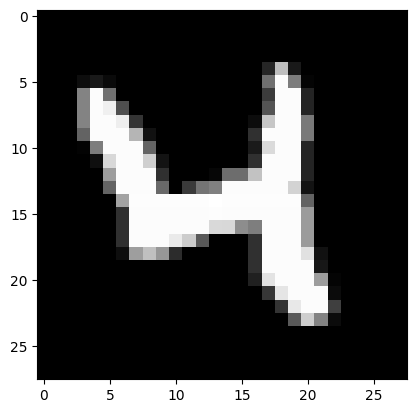

In [ ]:
import matplotlib.pyplot as plt

# image(data)
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28,28), cmap = "gray")

In [ ]:
# label
print(train_dataset[20][1])

4


In [ ]:
# Iterable Dataset

batch_size= 100
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

In [ ]:
len(train_dataset)

60000

In [ ]:
len(train_loader)

600

In [ ]:
print("Training Set (images) {}". format(len(train_dataset)))
print("Test Set (images) {}". format(len(test_dataset)))

print("Train Loaader Batches {}". format(len(train_loader)))
print("Test Loaader Batches {}". format(len(test_loader)))

Training Set (images) 60000
Test Set (images) 10000
Train Loaader Batches 600
Test Loaader Batches 100


# Model Class

In [ ]:
class CNN(nn.Module):

  def __init__(self):

    super(CNN, self).__init__()

    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
    self.batchnorm1 = nn.BatchNorm2d(8)
    self.relu = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    #MaxPool'den sonra her output feature map'i 14 (28/2)

    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    #MaxPool'den sonra her output feature map'i 7 (14/2)
    #Feature Map'leri Flatten'a tabi tut.
      # 32 feature map var ve her biri 7*7'lik.
      # 32*7*7 = 1568

    self.fc1 = nn.Linear(in_features=1568, out_features=600)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(in_features=600, out_features=10)

  def forward(self, x):
    x = self.cnn1(x)
    x = self.batchnorm1(x)
    x = self.relu(x)
    x = self.maxpool1(x)
    x = self.cnn2(x)
    x = self.batchnorm2(x)
    x = self.maxpool2(x)
    x = x.view(-1, 1568)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
iteration = 0
correct = 0

for i, (inputs, labels) in enumerate(train_loader):

  CUDA = torch.cuda.is_available()
  if CUDA:
    inputs = inputs.cuda()
    labels =  labels.cuda()

  print("Her bir iterasyonda...")
  print("Input shape : ", inputs.shape)
  print("Labels shape : ", labels.shape)
  output = model(inputs)
  print("Output shape : ", output.shape)
  _, predicted = torch.max(output,1)
  print("Predicted Shape : ", predicted.shape)
  print("Predicted Tensor :")
  print(predicted)
  correct += (predicted == labels).sum()
  break

Her bir iterasyonda...
Input shape :  torch.Size([100, 1, 28, 28])
Labels shape :  torch.Size([100])
Output shape :  torch.Size([100, 10])
Predicted Shape :  torch.Size([100])
Predicted Tensor :
tensor([8, 6, 5, 9, 9, 9, 6, 4, 9, 1, 6, 1, 8, 9, 1, 9, 9, 5, 4, 9, 6, 9, 6, 9,
        9, 5, 6, 6, 1, 1, 2, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 9, 5, 8, 6, 6, 6, 6,
        1, 6, 1, 6, 9, 6, 5, 1, 7, 9, 1, 9, 5, 9, 3, 1, 6, 4, 2, 1, 1, 6, 4, 8,
        6, 6, 6, 6, 8, 5, 6, 9, 9, 6, 9, 9, 6, 1, 1, 7, 7, 9, 9, 1, 1, 6, 7, 0,
        1, 6, 9, 6], device='cuda:0')


# Training in the Model

In [ ]:
num_epochs = 25

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
  correct = 0
  iterations = 0
  iter_loss = 0

  model.train()

  for i, (inputs, labels) in enumerate(train_loader):

    CUDA = torch.cuda.is_available()
    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    iter_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()        # update the weights

    _, predicted = torch.max(outputs,1)
    correct += (predicted == labels).sum()
    iterations += 1

  train_loss.append(iter_loss/iterations)
  train_accuracy.append((100*correct/len(train_dataset)))

  testing_loss = 0.0
  correct = 0
  iterations = 0

  model.eval()        # NN evulation mode'a sok.

  for i, (inputs, labels) in enumerate(test_loader):

    CUDA = torch.cuda.is_available()
    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    testing_loss += loss.item()

    _, predicted = torch.max(outputs,1)
    correct += (predicted == labels).sum()
    iterations += 1

  test_loss.append(testing_loss/iterations)
  test_accuracy.append((100*correct/len(test_dataset)))

  print("Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}"
  .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))


Epoch 1/25, Training Loss: 0.454, Training Accuracy: 87.735, Testing Loss: 0.149, Testing Acc: 95.900
Epoch 2/25, Training Loss: 0.156, Training Accuracy: 95.497, Testing Loss: 0.094, Testing Acc: 97.010
Epoch 3/25, Training Loss: 0.115, Training Accuracy: 96.595, Testing Loss: 0.077, Testing Acc: 97.420
Epoch 4/25, Training Loss: 0.095, Training Accuracy: 97.278, Testing Loss: 0.066, Testing Acc: 97.870
Epoch 5/25, Training Loss: 0.084, Training Accuracy: 97.502, Testing Loss: 0.065, Testing Acc: 97.980
Epoch 6/25, Training Loss: 0.073, Training Accuracy: 97.905, Testing Loss: 0.052, Testing Acc: 98.250
Epoch 7/25, Training Loss: 0.067, Training Accuracy: 98.040, Testing Loss: 0.048, Testing Acc: 98.440
Epoch 8/25, Training Loss: 0.061, Training Accuracy: 98.182, Testing Loss: 0.044, Testing Acc: 98.480
Epoch 9/25, Training Loss: 0.056, Training Accuracy: 98.350, Testing Loss: 0.042, Testing Acc: 98.600
Epoch 10/25, Training Loss: 0.052, Training Accuracy: 98.532, Testing Loss: 0.042,

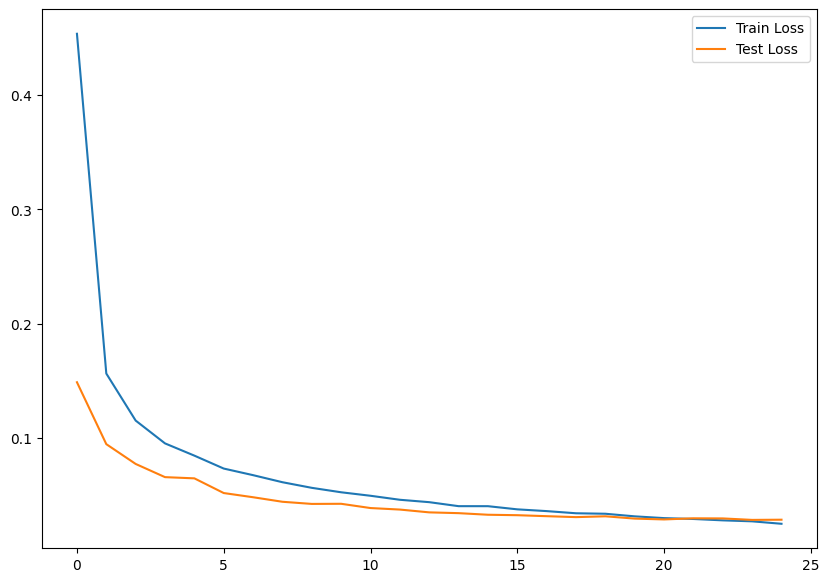

In [ ]:
# Plotting the Loss

fig = plt.figure(figsize=(10,7))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.legend()
plt.show()

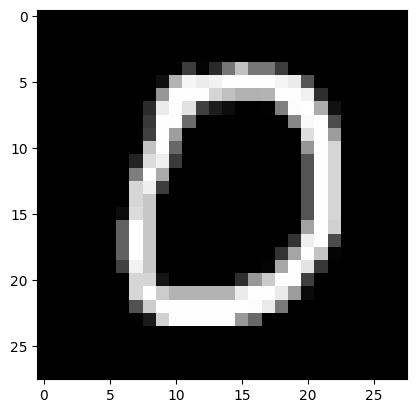

In [ ]:
plt.imshow(test_dataset[10][0].reshape(28,28), cmap="gray")

In [ ]:
def predict(img_name, model):
  image = cv2.imread(img_name, 0)
  ret, thresholded =  cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
  img = 255-thresholded
  cv2_imshow(img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  img = Image.fromarray(img)
  img = transforms_photo(img)
  img = img.view(1,1,28,28)
  img = Variable(img)

  model.eval()

  if torch.cuda.is_available():
    model = model.cuda()
    img = img.cuda()

    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output, 1)

    return predicted.item()



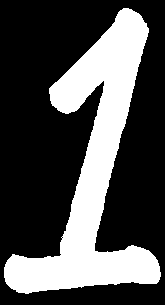

tensor([[-3.9486,  5.5649,  4.7064,  4.9905, -2.8724, -2.4366, -7.0591,  4.9414,
          0.3135, -1.6071]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-3.9486,  5.5649,  4.7064,  4.9905, -2.8724, -2.4366, -7.0591,  4.9414,
          0.3135, -1.6071]], device='cuda:0')
Tahmin edilen label : 1


In [ ]:
prediction = predict("bir.png", model)
print("Tahmin edilen label : {}".format(prediction))

In [ ]:
img = test_dataset[10][0].resize_((1,1,28,28))    # (batch_size, channels, height, width)
label = test_dataset[10][1]

model.eval()

CUDA = torch.cuda.is_available()
if CUDA:
  model = model.cuda()
  img = img.cuda()

output = model(img)
_, predicted = torch.max(output,1)
print("Tahmin edilen label : {}". format(predicted.item()))
print("Gerçek Label : {}".format(label))

Tahmin edilen label : 0
Gerçek Label : 0


In [ ]:
img = test_dataset[17][0].resize_((1,1,28,28))    # (batch_size, channels, height, width)
label = test_dataset[17][1]

model.eval()

CUDA = torch.cuda.is_available()
if CUDA:
  model = model.cuda()
  img = img.cuda()

output = model(img)
_, predicted = torch.max(output,1)
print("Tahmin edilen label : {}". format(predicted.item()))
print("Gerçek Label : {}".format(label))

Tahmin edilen label : 7
Gerçek Label : 7
